# Automatic Image Visualization
**Visualization:** Blue/green tissue images are automatically generated, with micron scaling in axis-label and colorbar showing display range of the stain (green; 16-bit).

**Samples:** 

   - Quenching condition optimization on adjacent pancreas and breast tumor sections
    
   - Double application of antibody panel on a single section of HER2+ TMA
    
   - Antibody order optimization on adjacent sections of HER2 + TMA

**Method**: Often images in publications are not reproducible: the ROI selected and the display range are not documented. This code allows for fully reproducible visualizations of image data.

In [2]:
#libraries
import os
import pandas as pd
import numpy as np
from itertools import compress
import shutil
import skimage
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
#os.chdir('/home/users/engje/cmif')
from mplex_image import preprocess, process, analyze, mpimage, cmif

In [3]:
%matplotlib inline

In [7]:
# set paths
#important paths
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation')
codedir = os.getcwd()
figdir = f'{codedir}/Figures'
preprocess.cmif_mkdir([figdir])
i_micron_per_pixel = .325

# Figure 2 a-d: Visualization of quenching

Download necessary images from synapse.org

syn23644741 https://www.synapse.org/#!Synapse:syn23644741

syn23644800 https://www.synapse.org/#!Synapse:syn23644800

syn23644827 https://www.synapse.org/#!Synapse:syn23644827

4165NPanc


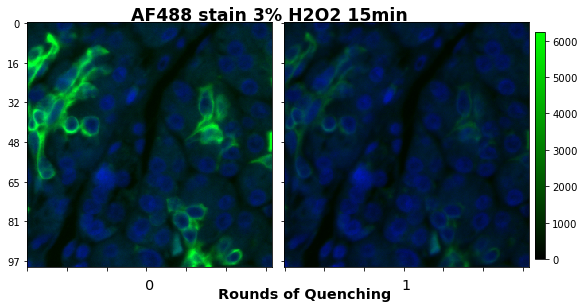

In [23]:
#quenching test 1,2,3

d_process = {
    '4165NPanc':f'{codedir}/Images/tiff/4165NPanc/SubtractedRegisteredImages',
    'B1640':f'{codedir}/Images/tiff/B1640/', 
    'NPPan4165':f'{codedir}/Images/tiff/NPPan4165/',
    }

d_color = {'c1':'DAPI','c2':'AF488','c3':'AF555','c4':'AF647','c5':'AF750'}

d_condition = {'4165NPanc-73':['stain 3% H2O2 15min',(2000,9200,308,308)],
 '4165NPanc-74':['blank 3% H2O2 15min',(2000,9200,308,308)],
 '4165NPanc-75':['stain 4.5% H2O2 15min',(1800,9000,308,308)],
 '4165NPanc-76':['blank 4.5% H2O2 15min',(2000,9200,308,308)],
 '4165NPanc-77':['stain 6% H2O2 15min',(2000,9200,308,308)],
 '4165NPanc-78':['blank 6% H2O2 15min',(2000,9200,308,308)],
 'B1640-T8-3':['blank 3% H2O2 30min ',(6598, 11293, 500, 500)],
 'B1640-T8-4':['stain 3% H2O2 60min',(13622, 19711, 500, 500)],
 'B1640-T8-5':['stain 3% H2O2 30min',(27667, 19773, 500, 500)], 
 'B1640-T8-6':['stain 3% H2O2 30min+light',(14181, 19870, 500, 500)],
 'NPPan4165-66':['blank no quench',(8000, 8155, 308, 308)],
 'NPPan4165-65':['blank 3% H2O2 30min+light',(7924, 9881, 308, 308)],
 }

d_ref = {'3%':'4165NPanc-73',
    '4.5%':'4165NPanc-75',
    '6%':'4165NPanc-77',
 }

for idx,(s_sample, s_path) in enumerate(d_process.items()):
    preprocess.cmif_mkdir([f'{figdir}/{s_sample}/pixel',f'{figdir}/{s_sample}'])
    print(s_sample)
    df_exp = pd.DataFrame()
    #match to czi to tiff names
    os.chdir(s_path)
    df_img_all = mpimage.parse_org(s_end = "_ORG.tif")
    if s_sample == '4165NPanc':
        df_img_all=pd.DataFrame()
        for s_dir in os.listdir():
            os.chdir(f'{s_path}/{s_dir}')
            df_img_all = df_img_all.append(mpimage.parse_org(s_end = "_ORG.tif"))
            os.chdir('..')
    for s_tissue in sorted(set([item.split('-Scene')[0] for item in df_img_all.scene])):
        df =pd.read_csv(f'{codedir}/Metadata/{s_sample}/{s_tissue}_ExposureTimes.csv',index_col=0)
        df_exp = df_exp.append(df)
    df_img_all['round_int'] = [int(item.split('R')[1]) for item in df_img_all.rounds]
    df_img_all['Rounds_of_Quenching'] = df_img_all.round_int - 1
    if s_sample == 'NPPan4165':
        df_img_all['Rounds_of_Quenching'] = df_img_all.round_int 
    df_img_all['tissue'] = [item.split('-Scene')[0] for item in df_img_all.scene]
    df_img_all = mpimage.add_exposure(df_img_all, df_exp,type='czi')
    for s_tissue in sorted(df_img_all.tissue.unique()):
        s_tissue_title = d_condition[s_tissue][0]
        if s_sample == '4165NPanc':
            s_ref_tissue = d_ref[s_tissue_title.split(' ')[1]]
            df_ref = df_img_all[df_img_all.tissue==s_ref_tissue]
            os.chdir(f'{s_path}/{s_tissue}')
        tu_crop = d_condition[s_tissue][1]
        df_img = df_img_all[df_img_all.tissue==s_tissue]
        df_dapi = df_img_all[(df_img_all.rounds=='R1') & (df_img_all.color=='c1')& (df_img_all.tissue==s_tissue)]
        df_img = df_img[df_img.color != 'c1']
        tu_array=(1,2)
        i_expnorm=0
        for s_color in sorted(set(df_img.color)):
            df_img_channel = (df_img[(df_img.color==s_color)&~(df_img.Rounds_of_Quenching.isin(['2','3','4','5','6']))]).sort_values(by='rounds')
            s_title = d_color[s_color] + ' ' + s_tissue_title
            if s_sample == '4165NPanc':
                s_r1 = f'{(df_ref[(df_ref.rounds=="R1") & (df_ref.color==s_color)]).index[0]}'
                os.chdir(f"{s_path}/{s_r1.split('_')[2].split('-Scene')[0]}")
                a_r1 = skimage.io.imread(s_r1)
                a_crop = a_r1[(tu_crop[1]):(tu_crop[1]+tu_crop[3]),(tu_crop[0]):(tu_crop[0]+tu_crop[2])]
                tu_rescale= (0, np.quantile(a_crop,0.98)+np.quantile(a_crop,0.98)/2)
                os.chdir(f'{s_path}/{s_tissue}')
            elif s_sample == 'B1640':
                tu_rescale = (0, 12000)
                i_expnorm=50
            else:
                tu_rescale = (0,8000)
            fig, ax = mpimage.array_roi_if(df_img_channel,df_dapi,s_label='Rounds_of_Quenching',s_title=s_title,tu_crop=tu_crop,
                 tu_array=tu_array,tu_fig=(9,4.5),tu_rescale=tu_rescale,i_expnorm=i_expnorm)
            fig.savefig(f'{figdir}/{s_sample}/pixel/IFarray_R1stainscaled_{s_tissue}_{s_tissue_title.split(" ")[1].replace("%","")}_{s_color}_pixelunits.png',dpi=200)
            ax[0].set_yticklabels([str(int(int(re.sub(u"\u2212", "-", item.get_text()))*i_micron_per_pixel)) for item in ax[0].get_yticklabels(minor=False)])
            fig.savefig(f'{figdir}/{s_sample}/IFarray_R1stainscaled_{s_tissue}_{s_tissue_title.split(" ")[1].replace("%","")}_{s_color}_micronunits.png', dpi=200)
            break
        break
    break
            #if s_tissue != '4165NPanc-73':
            #    if s_color != 'c2':
            #        plt.close(fig)


# Figure 2: Visualization of antibody order

Download necessary images from synapse.org

syn23644824 https://www.synapse.org/#!Synapse:syn23644824

syn23644825 https://www.synapse.org/#!Synapse:syn23644825

syn23644826 https://www.synapse.org/#!Synapse:syn23644826

Her2B-K154


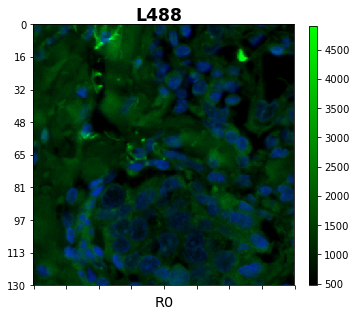

In [9]:
#antibody order 1,2

d_process = {
    'Her2B-K154':f'{codedir}/Images/tiff/K154/',
    'Her2B-K157':f'{codedir}/Images/tiff/K157/',
    'Her2B-K175':f'{codedir}/Images/tiff/K175/',
 }

d_crop ={'Her2B-K157-Scene-002':(2160,4350,400,400),
    'Her2B-K157-Scene-006':(4500,4100,400,400),
    'Her2B-K157-Scene-008':(2800,950,400,400),
    'Her2B-K154-Scene-002':(3014,3437,400,400),
    'Her2B-K154-Scene-006':(4154,4909,400,400),
    'Her2B-K154-Scene-008':(3101,1923,400,400),
    'HER2B-K175-Scene-02':(3443,3970,400,400),
    'HER2B-K175-Scene-06':(2925,4671,400,400),
    'HER2B-K175-Scene-08':(4593,4000,400,400),
  }

for idx,(s_sample, s_path) in enumerate(d_process.items()):
    preprocess.cmif_mkdir([f'{figdir}/{s_sample}/pixel',f'{figdir}/{s_sample}'])
    print(s_sample)
    tu_array=(1,1)
    tu_fig=(5.5,4.8)
    df_exp = pd.DataFrame()
    os.chdir(s_path)
    #add path info
    df_img = mpimage.parse_org()
    for s_tissue in sorted(set([item.split('-Scene')[0] for item in df_img.scene])):
        df =pd.read_csv(f'{codedir}/Metadata/{s_sample}/{s_tissue}_ExposureTimes.csv',index_col=0)
        df_exp = df_exp.append(df)
    if s_sample =='Her2B-K154':
        df_exp.index = [item.replace('Her2b-K154',s_sample) for item in df_exp.index]
        df_img=df_img[df_img.rounds!='R11Q']
    df_img['roundfloat'] = df_img.rounds.str.replace('Q','.5')
    df_img['_'] = df_img.rounds
    df_img['round_int'] = [float(item.split('R')[1]) for item in df_img.roundfloat]
    df_img = mpimage.add_exposure(df_img, df_exp,type='czi')

    #make arrays
    for s_index in df_img.index: 
        s_marker = df_img.loc[s_index,'marker']
        s_scene = df_img.loc[s_index,'scene']
        s_round = df_img.loc[s_index,'rounds']
        if s_marker == 'DAPI':
            continue
        df_dapi = df_img[(df_img.scene == s_scene) & (df_img.round_int == 2) & (df_img.color == 'c1')]
        df_et = df_img[df_img.index==s_index]
        #print(f'{s_marker}  {len(df_et)}')
        tu_crop = d_crop[s_scene]
        #visualize IF roi
        fig, ax = mpimage.array_roi_if(df_et,df_dapi,s_label='_',s_title=s_marker,tu_crop=tu_crop,
                tu_array=tu_array,tu_fig=tu_fig,tu_rescale=(0,0),i_expnorm=0)
        fig.savefig(f'{figdir}/{s_sample}/pixel/IFarray_{s_scene}_{s_marker}_{s_round}_pixelunits.png')
        ax[0].set_yticklabels([str(int(int(re.sub(u"\u2212", "-", item.get_text()))*i_micron_per_pixel)) for item in ax[0].get_yticklabels(minor=False)])
        fig.savefig(f'{figdir}/{s_sample}/IFarray_{s_scene}_{s_marker}_{s_round}_micronunits.png', dpi=200)
        break
    break
        #if s_path != 'Her2B-K157':
        #    if s_round=='R13':
        #        plt.close(fig)
        #    elif s_marker != 'CD45':
        #        plt.close(fig)

# Figure 2: Visualization of AF subtraction strategies

Download necessary images from synapse.org

syn23644795 https://www.synapse.org/#!Synapse:syn23644795

syn23644798 https://www.synapse.org/#!Synapse:syn23644798

44290-146_R0


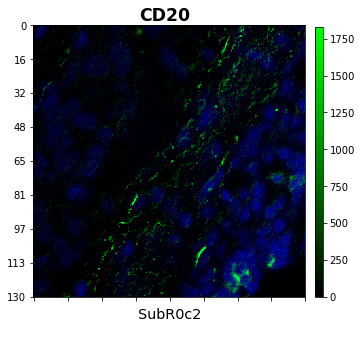

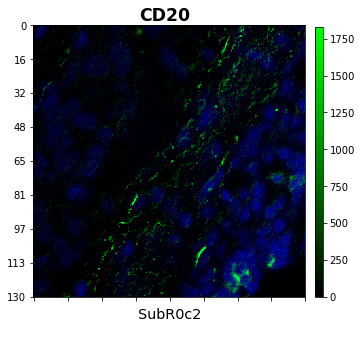

In [24]:
# AF subtraction r0, r8

d_process = {
    '44290-146_R0':f'{codedir}/Images/tiff/44290-146_R0',
    '44290-146_R8Q':f'{codedir}/Images/tiff/44290-146_R8',
    #'44290-146':f'{codedir}/Images/tiff/44290-146',
   }

for idx,(s_sample, s_path) in enumerate(d_process.items()):
    preprocess.cmif_mkdir([f'{figdir}/{s_sample}/pixel',f'{figdir}/{s_sample}'])
    print(s_sample)
    tu_array=(1,1)
    tu_fig=(5.5,5)
    os.chdir(s_path)
    #add path info
    df_img = mpimage.parse_org()
    df_img['_'] =  [item.split('_')[3] for item in df_img.index]
    for s_index in df_img.index: 
        s_marker = df_img.loc[s_index,'marker']
        s_scene = df_img.loc[s_index,'scene']
        s_round = df_img.loc[s_index,'rounds']
        s_sub = df_img.loc[s_index,'_']
        tu_rescale=(0,0)
        if s_marker == 'DAPI':
            continue
        elif s_marker == 'R8Qc2':
            tu_rescale = (900,7100)
        df_dapi = df_img[(df_img.scene == s_scene) & (df_img.rounds == 'R2') & (df_img.color == 'c1')]
        df_et = df_img[df_img.index==s_index]
        #print(f'{s_marker}  {len(df_et)}')
        tu_crop = (2550,10150, 400, 400)
        #visualize IF roi
        
        fig, ax = mpimage.array_roi_if(df_et,df_dapi,s_label='_',s_title=s_marker,tu_crop=tu_crop,
            tu_array=tu_array,tu_fig=tu_fig,tu_rescale=tu_rescale,i_expnorm=0)
        fig.savefig(f'{figdir}/{s_sample}/pixel/IFarray_{s_sample}_{s_marker}_{s_sub}_pixelunits.png')
        ax[0].set_yticklabels([str(int(int(re.sub(u"\u2212", "-", item.get_text()))*i_micron_per_pixel)) for item in ax[0].get_yticklabels(minor=False)])
        fig.savefig(f'{figdir}/{s_sample}/IFarray_{s_sample}_{s_marker}_{s_sub}_micronunits.png',dpi=200)
        
        #visualize IF roi with borders
        os.chdir(f'{s_path}/Borders')
        df_border = mpimage.parse_org(type='raw')
        df_border.index = './Borders/' + df_border.index
        os.chdir(s_path)
        if len(set(df_border.marker).intersection(set([s_marker]))) ==1:
            fig, ax, a_crop_border = mpimage.roi_if_border(df_et,df_dapi,df_border,s_label='_',s_title=s_marker,tu_crop=tu_crop,tu_array=tu_array,tu_fig=tu_fig,tu_rescale=tu_rescale,i_expnorm=0)
            fig.savefig(f'{figdir}/{s_sample}/pixel/IFborder_{s_sample}_{s_marker}_{s_sub}_pixelunits.png')
            ax[0].set_yticklabels([str(int(int(re.sub(u"\u2212", "-", item.get_text()))*i_micron_per_pixel)) for item in ax[0].get_yticklabels(minor=False)])
            fig.savefig(f'{figdir}/{s_sample}/IFborder_{s_sample}_{s_marker}_{s_sub}_micronunits.png',dpi=200)
        break
    break